# Stanford Dogs Classification Using CNNs


In [1]:
import tensorflow as tf
from tensorflow.keras import datasets, callbacks
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import InputLayer, Dense, Conv2D, \
                Flatten, MaxPooling2D, BatchNormalization, Dropout, \
                RandomFlip, RandomRotation, RandomZoom, Resizing, Input, \
                Rescaling, GlobalAveragePooling2D

from tensorflow.keras.optimizers import Adam, SGD

import tensorflow_datasets as tfds

from matplotlib import pyplot as plt, gridspec as gridspec
from random import randint
import numpy as np

In [2]:
tf.keras.backend.clear_session()

In [3]:
tf.__version__, tf.config.list_physical_devices('GPU')

('2.8.0', [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')])

### Prepare and visualise the dataset

In [4]:
num_classes = 120
input_shape = (224, 224, 3)
batch_size = 16

Let's first load the data and split it into the training images and their labels, and testing images and their labels

In [5]:
(train_ds, val_ds, test_ds), metadata = tfds.load(
    'StanfordDogs',
    split=['train[:80%]', 'train[80%:]', 'test'],
    with_info=True,
    as_supervised=False,
)

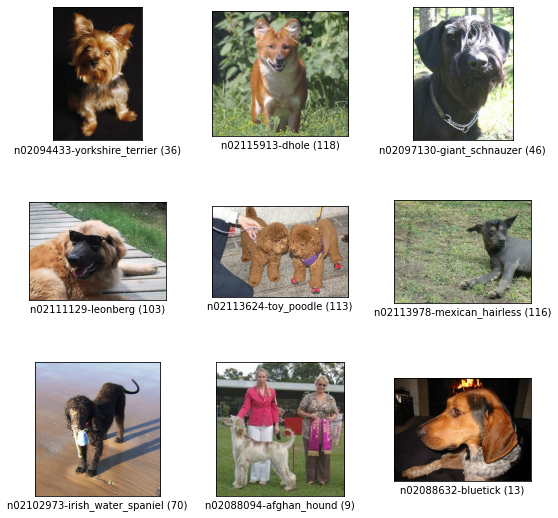

In [6]:
fig = tfds.show_examples(train_ds, metadata)

* We will crop the dogs using the first bounding box

Note we could also try without cropping to see the effect on training and testing performance. There is likely to be a trade-off here, 
cropping will ensure we're training the model on dogs only, but at inference time we are unlikely to get images cropped nearly
around the dogs

In [7]:
def preprocess(ds_row):
    image = tf.expand_dims(
        tf.image.convert_image_dtype(ds_row['image'], dtype=tf.float32), axis=0
    )
    label = ds_row['label']
    bboxes = ds_row['objects']['bbox']

    # Note this is getting the first dog in the image only if there are multiple dogs
    box_indices = tf.zeros(tf.shape(bboxes)[0], tf.int32)
    images = tf.image.crop_and_resize(
        image, 
        bboxes, 
        box_indices, 
        crop_size=(224, 224), 
    )
    return images[0], label

In [8]:
aug_train_ds = train_ds.map(
    lambda ds_row: preprocess(ds_row)
)  

aug_val_ds = val_ds.map(
    lambda ds_row: preprocess(ds_row)
)  

### Visualise the dataset

In [10]:
def visualize_predictions(dataset, model=None, number_of_samples=4):
# dataset = aug_train_ds
# number_of_samples = 4
# model = None

    img_batch = dataset.take(number_of_samples)
    pred_batch = model.predict(img_batch) if model else None

    print(img_batch)
    images = np.array([i[0] for i in img_batch])
    preds = np.array([p for p in pred_batch]) if pred_batch is not None else np.ones_like(images)

    fig = plt.figure(figsize=(20, 10))
    outerGrid = gridspec.GridSpec(1, 2, wspace=0.1, hspace=0.1)

    for i in range(2):        
        innerGrid = gridspec.GridSpecFromSubplotSpec(2, 2, subplot_spec=outerGrid[i], wspace=0.05, hspace=0.05)

        for j in range(4):
            ax = plt.Subplot(fig, innerGrid[j])
            if (i == 1):
                ax.imshow(preds[j])
            else:
                ax.imshow(images[j])

            ax.axis('off')
            fig.add_subplot(ax)

    plt.show()

<TakeDataset element_spec=(TensorSpec(shape=(224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>


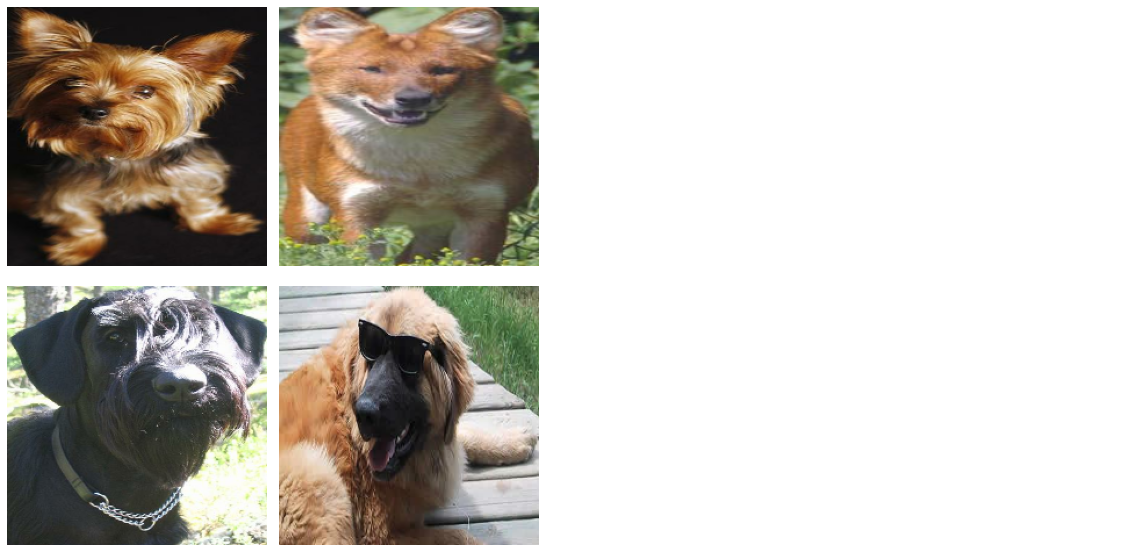

In [11]:
visualize_predictions(aug_train_ds)

### Building the Model

To remind you, a CNN model looks like this: Input ==> conv ==> pooling ==> flatten into 1D ==> dense ==> output

In [12]:
base_model = tf.keras.applications.efficientnet.EfficientNetB0(
    weights='imagenet', 
    input_shape=input_shape,
    include_top=False, 
    classes=num_classes)

*Note*: each Keras Application expects a specific kind of input preprocessing. For EfficientNet, input preprocessing is included as part of the model (as a Rescaling layer), and thus tf.keras.applications.efficientnet.preprocess_input is actually a pass-through function. EfficientNet models expect their inputs to be float tensors of pixels with values in the [0-255] range.

In [13]:
inputs = Input(shape=input_shape)
x = base_model(inputs, training=True)
x = GlobalAveragePooling2D()(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
outputs = Dense(num_classes, activation='softmax')(x)

model = tf.keras.Model(inputs, outputs)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional)  (None, 7, 7, 1280)       4049571   
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 batch_normalization (BatchN  (None, 1280)             5120      
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 1280)              0         
                                                                 
 dense (Dense)               (None, 120)               153720

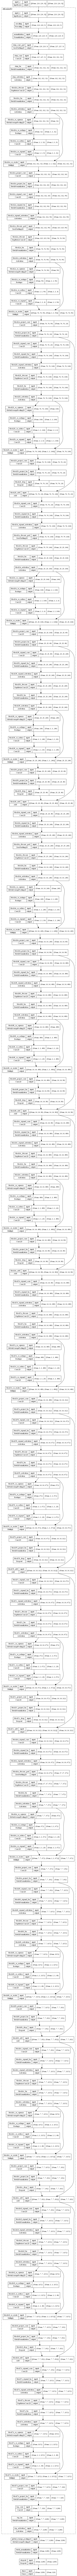

In [14]:
tf.keras.utils.plot_model(
    model,
    to_file='model.png',
    show_shapes=True,
    show_layer_names=True,
    expand_nested=True,
)

* Configure callbacks

In [15]:
early_stop = callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_on_plateau = callbacks.ReduceLROnPlateau(monitor='val_loss', mode='min', patience=5, factor=0.5, min_lr= 1e-6, verbose=1)

* Compile the model

We use adam as an optimizer and sparse categorical cross entropy for loss.

In [16]:
model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy', ],
    
)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional)  (None, 7, 7, 1280)       4049571   
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 batch_normalization (BatchN  (None, 1280)             5120      
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 1280)              0         
                                                                 
 dense (Dense)               (None, 120)               153720

### Testing and Evaluating


In [17]:
history = model.fit( 
    aug_train_ds.batch(batch_size),
    validation_data=aug_val_ds.batch(batch_size),
    epochs=20, 
    callbacks=[reduce_on_plateau]
)

Epoch 1/20
600/600 [==============================] - 81s 112ms/step - loss: 4.5838 - accuracy: 0.1094 - val_loss: 2.3078 - val_accuracy: 0.4067 - lr: 1.0000e-04
Epoch 2/20
600/600 [==============================] - 66s 109ms/step - loss: 2.0298 - accuracy: 0.4597 - val_loss: 1.4687 - val_accuracy: 0.5879 - lr: 1.0000e-04
Epoch 3/20
600/600 [==============================] - 66s 110ms/step - loss: 1.2450 - accuracy: 0.6404 - val_loss: 1.2403 - val_accuracy: 0.6329 - lr: 1.0000e-04
Epoch 4/20
600/600 [==============================] - 68s 113ms/step - loss: 0.8052 - accuracy: 0.7578 - val_loss: 1.1278 - val_accuracy: 0.6737 - lr: 1.0000e-04
Epoch 5/20
600/600 [==============================] - 66s 110ms/step - loss: 0.5519 - accuracy: 0.8381 - val_loss: 1.1157 - val_accuracy: 0.6712 - lr: 1.0000e-04
Epoch 6/20
600/600 [==============================] - 66s 109ms/step - loss: 0.3935 - accuracy: 0.8872 - val_loss: 1.0796 - val_accuracy: 0.6850 - lr: 1.0000e-04
Epoch 7/20
600/600 [========

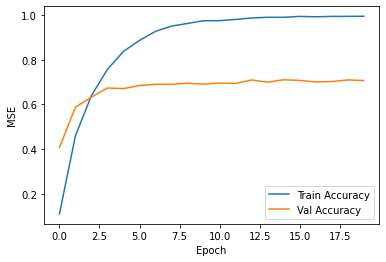

In [18]:
hist = history.history
plt.figure()
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.plot(history.epoch, hist['accuracy'], label='Train Accuracy')
plt.plot(history.epoch, hist['val_accuracy'], label = 'Val Accuracy')
plt.legend()

* Evaluate model performance

In [19]:
aug_test_ds = test_ds.map(
    lambda ds_row: preprocess(ds_row)
) 

In [20]:
model.evaluate(aug_test_ds.batch(batch_size))

537/537 [==============================] - 14s 25ms/step - loss: 1.0564 - accuracy: 0.7188


[1.0564018487930298, 0.7187645435333252]

* Save the trained model

In [21]:
model.save('stanford-dogs-efficientnet')

INFO:tensorflow:Assets written to: stanford-dogs-efficientnet\assets


INFO:tensorflow:Assets written to: stanford-dogs-efficientnet\assets


### Predict using the trained model and render confusion matrix

In [22]:
preds = np.array(tf.math.argmax(model.predict(aug_test_ds.batch(batch_size)), axis=1))

test_labels = [y for x, y, in aug_test_ds]
test_labels

import pandas as pd
conf_matrix = np.array(tf.math.confusion_matrix(
    test_labels, 
    preds
))

,0,1,2,3,4,5,6,7,8,9,...,110,111,112,113,114,115,116,117,118,119
0,29,0,0,1,0,0,1,6,0,0,...,2,1,1,0,0,0,0,0,0,0
1,0,68,0,4,2,4,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,117,2,4,0,0,0,0,0,...,0,0,0,6,1,0,0,0,0,0
3,0,5,2,33,2,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
4,0,0,1,7,76,0,0,0,0,1,...,0,0,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
115,0,0,0,0,0,0,0,0,0,0,...,0,0,0,3,8,31,0,0,0,0
116,2,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,1,41,0,0,0
117,0,0,0,0,0,0,0,0,0,0,...,0,1,1,0,0,0,1,38,4,0
118,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,2,48,0


Text(0.5, 114.0, 'Predicted label')

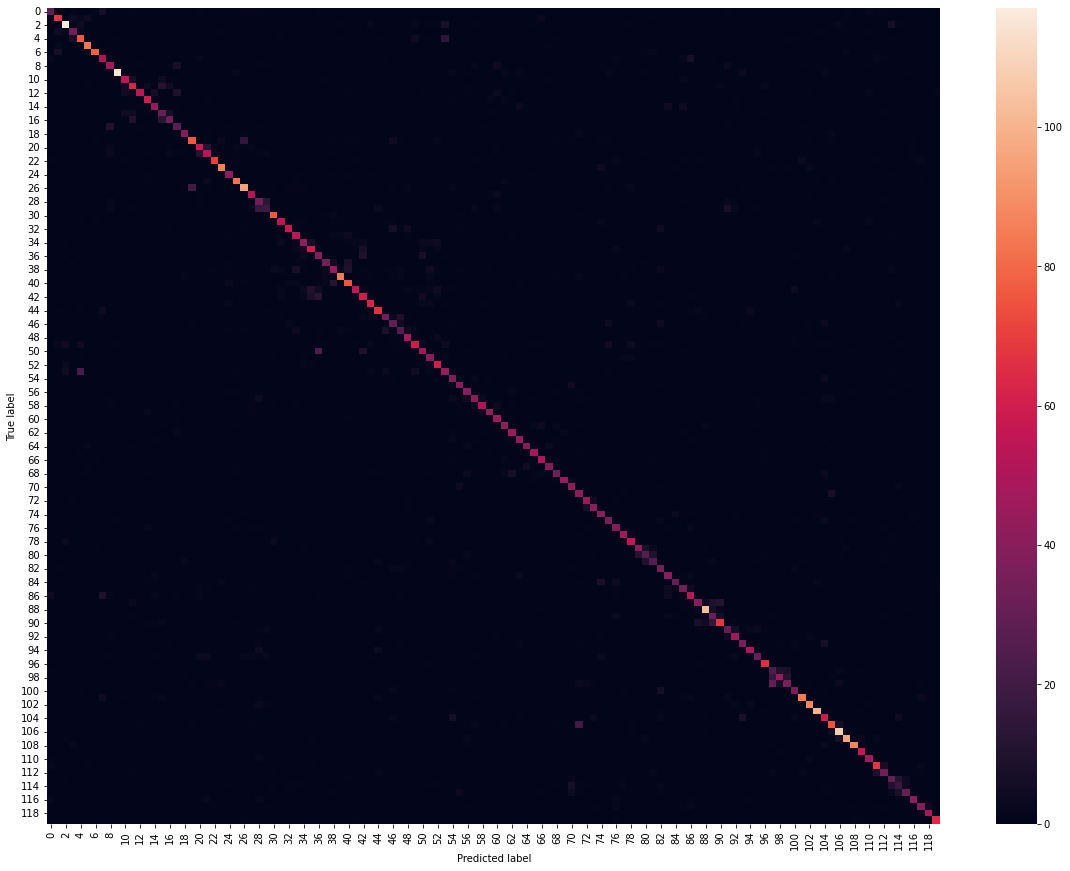

In [26]:
import seaborn as sns
plt.figure(figsize=(20,15))
sns.heatmap(conf_matrix)
plt.ylabel('True label')
plt.xlabel('Predicted label')